<a href="https://colab.research.google.com/github/maxbentley/datasciencefund/blob/main/Unit7/Max_BentU7Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 7 Project: Projecting Emmanuel Clase's fastball velocity using a Gaussian Process

I'm doing baseball again! This time, I'm going to try to use a Hilbert Space Gaussian Process to model the fastball velocity of the past three seasons of Emmanuel Clase. Why Emmanuel Clase? Because he has the highest amount of appearances of all relief pitchers, with 226 games played (excluding postseason play). This means that we will have a large amount of data to play around with.

## Setup

I first tried to gather this data from FanGraphs, but unfortunately the "export data" button on the rolling player graph section throws an internal server error, which means I'll have to use the pybaseball package to gather the data.

In [1]:
!pip install pybaseball

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 17.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from pybaseball import playerid_lookup

In [3]:
!pip install preliz
import preliz as pz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.1/517.1 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 18.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [4]:
from pybaseball import statcast_pitcher

In [ ]:
playerid_lookup("Clase", "Emmanuel") # mlb player ID of 661403, fangraphs ID of 21032

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,clase,emmanuel,661403,clase001,claseem01,21032,2019.0,2024.0


In [5]:
data = statcast_pitcher('2022-03-30', '2024-11-01', player_id = 661403) # gather all of the data for every pitch thrown in every game between these two dates

Gathering Player Data


In [6]:
data = data.query("pitch_type == 'FC'") # specify fastballs

In [7]:
date_speed = data.groupby('game_date', as_index=False)['release_speed'].mean() # group same-dates together, average pitch velo

<Axes: xlabel='game_date', ylabel='release_speed'>

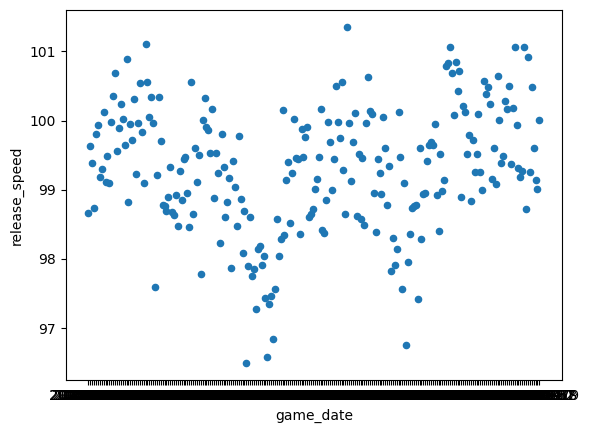

In [ ]:
date_speed.plot(kind="scatter", x="game_date", y="release_speed") # plot

That's a really interesting graph! It kind of looks like a sinusoidal wave, which makes a little bit of sense, as pitchers often decrease their effectiveness as the season goes on, improving over the offseason. This could especially be true for Emmanuel Clase, one of the best relievers in the game right now (and used heavily by the Guardians). This gives me some hope that a Hilbert-space Gaussian Process could work, as they are based on sinusoidal curves.

## Attempt 1

For my first model attempt, I tried to essentially just re-create the Gaussian Process found in the Unit 7 notes with this new dataset.

In [8]:
# convert from pandas df column to numpy array
release_speed = date_speed['release_speed'].to_numpy()

The following for loop is a little convoluted, let me explain what's going on:

We need to have some way of allowing pymc to understand the time series data, separated by season. To do this, instead of just making the dates purely sequential (starting at 0 and going from there), I've made it so that the first digit of each value (i.e. date) indicates the season it happened in (for example, a value of 134 would refer to the **thirty-fifth** date in 2023, the **second** season in the database, as they both start from zero). This has the intended effect of making the dates separated by an integer of 20-25, which could be notable.

In [9]:
game_date = date_speed['game_date'].to_numpy()

count = 0
for i in range(len(game_date)):
    if game_date[i][0:4] == '2022':
        game_date[i] = '0' + str(count).zfill(2) # zfill(2) ensures that there won't be duplicate low values
        count += 1
    elif game_date[i][0:4] == '2023':
        if game_date[i-1][0] == '0':
          count = 0
        game_date[i] = '1' + str(count).zfill(2)
        count += 1
    else:
        if game_date[i-1][0] == '1':
            count = 0
        game_date[i] = '2' + str(count).zfill(2)
        count += 1

In [10]:
game_date = game_date.astype(int)
game_date # Note the jumps between seasons (80->100, 175->200)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 22

<Axes: xlabel='game_date', ylabel='release_speed'>

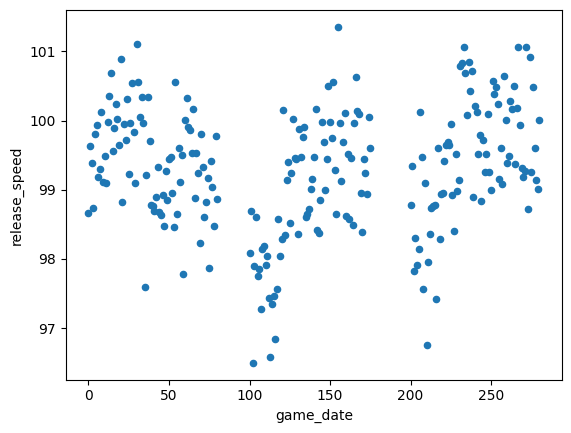

In [ ]:
plot_data = pd.DataFrame({'game_date': game_date, 'release_speed': release_speed})
plot_data.plot(kind="scatter", x="game_date", y="release_speed")

In [11]:
# for unknown reasons, pymc requires a list of integers that are themselves lists. this converts them
game_date = game_date.tolist()
for i in range(len(game_date)):
    game_date[i] = [game_date[i]]

game_date = np.array(game_date)

In [12]:
# Copied from notes, exercises
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [26]:
with pm.Model() as model_hsgp:
    #prior for our smoothness parameter
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(game_date))

    #this is our kernal, which decides how our points relate to one another
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    #this specfices that we're using an HSGP
    gp = pm.gp.HSGP(m=[10], c=1.5, cov_func=cov) # Note: I did not change the m and c parameters from the notes
                                                 # because I don't entirely understand how they work

    #f is for function, as in the function we use to transform our data
    f = gp.prior('f', X=game_date)
    #prior for the neg binomial
    α = pm.HalfNormal('α', 1)
    #likelihood
    y = pm.Normal("y", np.exp(f), α, observed=release_speed)

    idata_hsgp = pm.sample()

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x79bd34d34180>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.

Output()

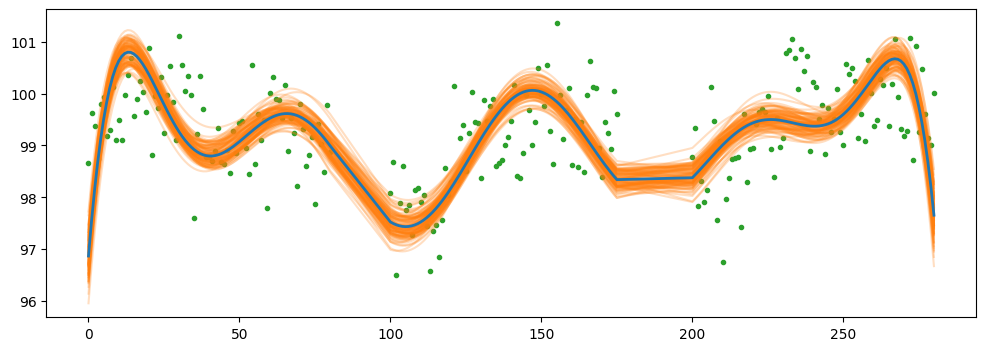

In [27]:
#set up plot
_, ax = plt.subplots(1, 1, figsize=(12, 4))
#plot raw data
ax.plot(date_speed["game_date"].values, date_speed["release_speed"].values, "C2.")

#grab posterior
f = az.extract(idata_hsgp, group="posterior", var_names="f")


idx = np.argsort(date_speed["game_date"].values)
#plot samples of the posterior
ax.plot(date_speed["game_date"].values[idx], np.exp(f.values[idx,:100]), alpha=0.25, color="C1")
#plot posterior mean
ax.plot(date_speed["game_date"].values[idx], np.exp(f.values[idx].mean(1)), color="C0", lw=2)

Whoa! It worked! I'm going to be honest - I did not expect that to run. First things first - the two big jumps/cusps in the data were caused by the difference between seasons, which makes sense - I explicitly intended for the seasons to have some game_date difference. The problem arises, however, when we take a look at some of the model's fitting choices. The model overall gets correct that there seems to be a sinusoidal trend, but seemingly over and under-estimates the data at times. The initial upswing looks like it starts a little low and goes too high; the upswing after the season change falls victim to this same trend, and it looks like the model overfits at the very end, predicting a sharp downward trend when there's no evidence to think so. There's clearly some room for improvement here. Let's see the posterior predictive check:

In [38]:
pm.sample_posterior_predictive(idata_hsgp, model=model_hsgp, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

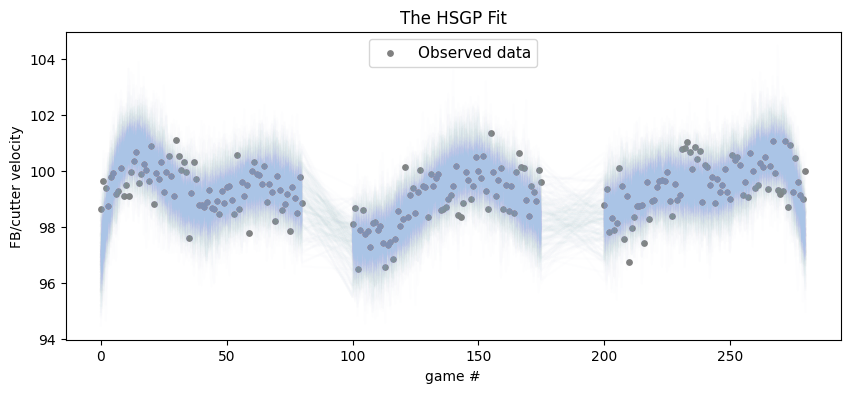

In [43]:
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

y_preds = az.extract(idata_hsgp.posterior_predictive.sel(draw=slice(None, None, 10)), var_names="y")

ax.plot(game_date, y_preds, color="#AAC4E6", alpha=0.02)
ax.scatter(game_date, release_speed, marker="o", color="grey", s=15, label="Observed data")

ax.set(title="The HSGP Fit", xlabel="game #", ylabel="FB/cutter velocity")
ax.legend(frameon=True, fontsize=11, ncol=2);

Note: I got the above code from Bianca, who in turn got it from this article on the [pymc documentation](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/HSGP-Basic.html).

This pretty much confirms what I was saying above. The GP's initial and final swings don't make any sense, but the rest of the data is estimated pretty well, save for a few concentrations of outliers. The 2023 season especially seems to lend itself well to this analysis.

## Attempt 2: Gapless Gaussian Process

For my second attempt, I'm going to essentially try to do the same thing, but remove any explicit separation between the seasons like there was in the first. This could help the model understand the flow between each season and maybe help it understand the data better.

In [45]:
date_nogaps = date_speed['game_date'].to_numpy()

count = 0
for i in range(len(date_nogaps)):
  date_nogaps[i] = count
  count += 1 # instead of checking for each season, each date is just sequential

In [46]:
date_nogaps = date_nogaps.astype(int)
date_nogaps # There are now no "jumps" between seasons (80->81, etc)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [47]:
date_nogaps = date_nogaps.tolist()
for i in range(len(date_nogaps)):
    date_nogaps[i] = [date_nogaps[i]]

date_nogaps = np.array(date_nogaps)

In [48]:
with pm.Model() as hsgp_nogap:
    #prior for our smoothness parameter
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(date_nogaps))

    #this is our kernal, which decides how our points relate to one another
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    #this specfices that we're using an HSGP
    gp = pm.gp.HSGP(m=[10], c=1.5, cov_func=cov) # Note: I did not change the m and c parameters from the notes
                                                 # because I don't entirely understand how they work at the moment

    #f is for function, as in the function we use to transform our data
    f = gp.prior('f', X=date_nogaps)
    #prior for the neg binomial
    α = pm.HalfNormal('α', 1)
    #likelihood
    y = pm.Normal("y", np.exp(f), α, observed=release_speed)

    idata_hgsp_nogap = pm.sample()

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x79bd610e4040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.

Output()

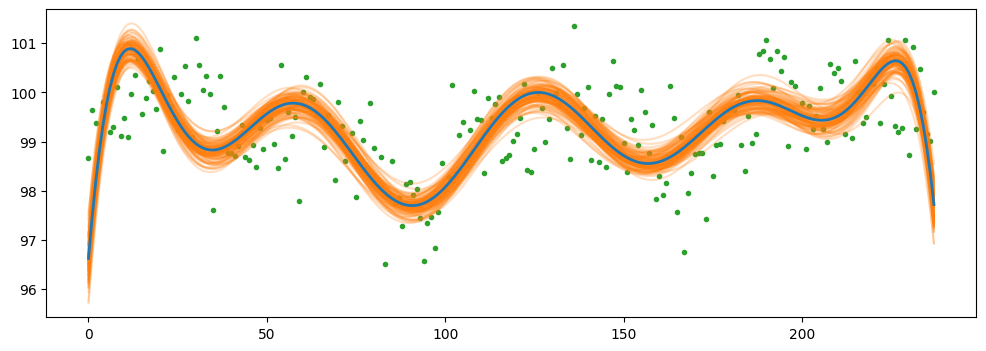

In [49]:
#set up plot
_, ax = plt.subplots(1, 1, figsize=(12, 4))
#plot raw data
ax.plot(date_speed["game_date"].values, date_speed["release_speed"].values, "C2.")

#grab posterior
f = az.extract(idata_hgsp_nogap, group="posterior", var_names="f")


idx = np.argsort(date_speed["game_date"].values)
#plot samples of the posterior
ax.plot(date_speed["game_date"].values[idx], np.exp(f.values[idx,:100]), alpha=0.25, color="C1")
#plot posterior mean
ax.plot(date_speed["game_date"].values[idx], np.exp(f.values[idx].mean(1)), color="C0", lw=2)

I think this is still not great. Obviously, the cusps and jumps are gone (as expected), but the problems with the actual fit is still there. Perhaps morst glaringly, the entire first season seems even worse than before--there's an entire curve that seems completely nonsensical, moving below the data and then back up. It seems as though separating the seasons was the way to go. Let's see the posterior predictive:

In [51]:
pm.sample_posterior_predictive(idata_hgsp_nogap, model=hsgp_nogap, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

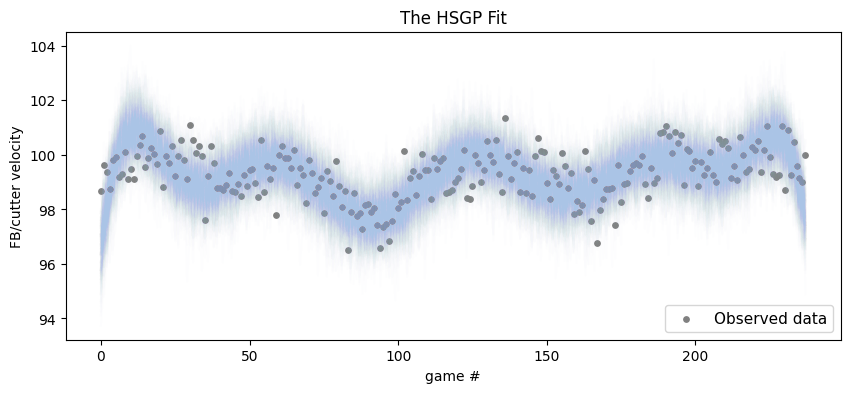

In [52]:
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

y_preds = az.extract(idata_hgsp_nogap.posterior_predictive.sel(draw=slice(None, None, 10)), var_names="y")

ax.plot(date_nogaps, y_preds, color="#AAC4E6", alpha=0.02)
ax.scatter(date_nogaps, release_speed, marker="o", color="grey", s=15, label="Observed data")

ax.set(title="The HSGP Fit", xlabel="game #", ylabel="FB/cutter velocity")
ax.legend(frameon=True, fontsize=11, ncol=2);

Interesting, the full fit seems to be about the same. The problems at the ends are still there (seemingly due to the nature of how we constructed the GPs themselves), and the problem I raised earlier during my mean analysis is there, but once the GP gets into the swing of things, it works pretty well, save for a few outliers.

## Conclusion

I *way* over-complicated this. The time-series data, as I had hoped, did lend itself to a Gaussian Process well, but the model that performed the best out of the two--the season-separated GP--would likely have been better off just being a b-spline. The GP worked very well, but probably did some overfitting. Looking at the separated data, it honestly might have fit about the same if I had just used three different lines--near the most bare-bones predictive effort.